In [3]:
# Hello World

In [4]:
import torch
import torchvision.transforms as T
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from torch import tensor

In [5]:
# You can downlaod the dataset using: kaggle competitions download -c imagenet-object-localization-challenge

# Utils

In [80]:
def display_image(img):
        with torch.no_grad():
                img = img.permute((1, 2, 0))
                plt.imshow(img.cpu().numpy())
                plt.show()

def display_images(imgs):
        with torch.no_grad():
                for i, img in enumerate(imgs):
                        plt.subplot(1, len(imgs), i+1)
                        img = img.permute((1, 2, 0))
                        plt.imshow(img.cpu().numpy())

def get_center_of_image(img, size=64):
        return T.CenterCrop((size, size))(img)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloading

In [81]:
IMAGE_SIZE = 128
CENTER_SIZE = 64
train_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

sanity_transforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.CenterCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [82]:
# 1 is gold fish, 99  is goose 
# classes =  [1, 99]
# 980: volcano
classes =  [980]
# imagenet_dataset.class_to_idx

In [115]:
DATASET_PATH = '/pub2/imagenet/ILSVRC/Data/CLS-LOC/train'
imagenet_dataset = ImageFolder(root=DATASET_PATH, transform=sanity_transforms)
# sanity_imagenet_dataset = ImageFolder(root=DATASET_PATH, transform=sanity_transforms)

idx = [i for i in range(len(imagenet_dataset)) if imagenet_dataset.imgs[i][1] in classes]
train_subset = torch.utils.data.Subset(imagenet_dataset, idx)

sanity_subset = torch.utils.data.Subset(train_subset, [1])

In [116]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
sanity_loader = DataLoader(sanity_subset, batch_size=1, shuffle=True)

In [117]:
sample_batch = next(iter(sanity_loader))
sample_image = sample_batch[0][0]
sample_image = sample_image.float()
# sample_image = sample_image.unsqueeze(0)
print(sample_image.min(), sample_image.max())

tensor(0.) tensor(1.)


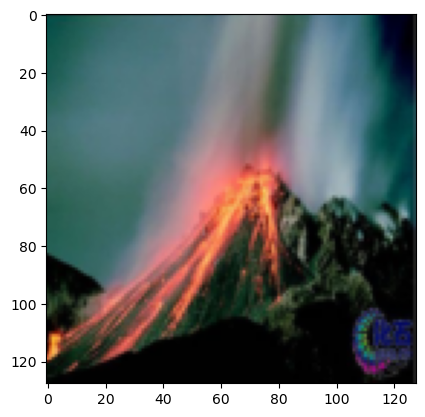

In [121]:
display_image(sample_image)
# for i in range(0, 10):
# 	display_image(sample_batch[0][i])
plt.show()

# Network

In [122]:
LATENT_SPACE_DIM = 4000
HIDDEN_LAYER_SIZE = 64

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        # self.conv_t1 = nn.ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=0 )
        # self.conv_1 = nn.Conv2d(128, 90, kernel_size=5, padding=1)
        # self.batch_norm_1 = nn.BatchNorm2d(90)
        # self.conv_2 = nn.Conv2d(90, 128, kernel_size=5, padding=1)
        # self.batch_norm_2 = nn.BatchNorm2d(128)
        # self.conv_t2 = nn.ConvTranspose2d(128, 3, kernel_size=5, stride=4, padding=0, output_padding=0 )
        # self.conv_final = nn.Conv2d(3, 3, 1)
        # self.num_classes = 5

        # (128, 128) -> (64, 64)
        self.conv1 = nn.Conv2d(3, HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  

        # (64, 64) -> (32, 32)
        self.conv2 = nn.Conv2d(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)

        # (32, 32) -> (16, 16)
        self.conv3 = nn.Conv2d(HIDDEN_LAYER_SIZE, 2 * HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  # 16x16 => 8x8

        # (16, 16) -> (8, 8)
        self.conv4 = nn.Conv2d(2 * HIDDEN_LAYER_SIZE, 4 * HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)

        # (8, 8) -> (4, 4)
        self.conv5 = nn.Conv2d(4 * HIDDEN_LAYER_SIZE, 8*HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  # 8x8 => 4x4
        self.flatten = nn.Flatten()

        # (4, 4) -> (Latence_Space_Dim)
        self.linear = nn.Linear(4*4 * (8* HIDDEN_LAYER_SIZE), LATENT_SPACE_DIM)

    def forward(self, inp):
        # print(inp.shape)
        inp = F.leaky_relu(self.conv1(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv2(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv3(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv4(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv5(inp))
        inp = self.flatten(inp)

        # print(inp.shape)
        inp = F.leaky_relu(self.linear(inp))
        # Encoder
        # original_inp = inp
        # inp = self.resnet.conv1(inp)
        # inp = self.resnet.bn1(inp)
        # inp = self.resnet.relu(inp)
        # skip = inp.clone()
        # inp = self.resnet.maxpool(inp)
        # inp = self.resnet.layer1(inp)
        # inp = self.resnet.layer2(inp)
        # inp = self.resnet.layer3(inp)
        # inp = self.resnet.layer4(inp)
        # print("fully encoded shape is", inp.shape)
        return inp

In [123]:
encoder = Encoder()
encoder = encoder.to(device)
encoder(sample_image.to(device).unsqueeze(0)).shape
# # sample_untrained_out = try_running_image(sample_image, encoder, decoder)
# display_images([sample_untrained_out, sample_image])

torch.Size([1, 4000])

In [124]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

        # (LATENT_SPACE_DIM) -> (4 , 4)
        self.linear = nn.Linear(LATENT_SPACE_DIM, 4*4*8*HIDDEN_LAYER_SIZE)

        # (4, 4) -> (8 , 8)
        self.conv_t1 = nn.ConvTranspose2d(8*HIDDEN_LAYER_SIZE, 4*HIDDEN_LAYER_SIZE, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(4*HIDDEN_LAYER_SIZE)

        # (8, 8) -> (16, 16)
        self.conv_t2 = nn.ConvTranspose2d(4*HIDDEN_LAYER_SIZE, 2*HIDDEN_LAYER_SIZE , kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(2*HIDDEN_LAYER_SIZE)

        # (16, 16) -> (32, 32)
        self.conv_t3 = nn.ConvTranspose2d(2*HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(HIDDEN_LAYER_SIZE)

        # (32, 32) -> (64, 64)
        self.conv_t4 = nn.ConvTranspose2d(HIDDEN_LAYER_SIZE, 3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        # self.batch_norm_4 = nn.BatchNorm2d(3)

        # self.conv = nn.Conv2d(HIDDEN_LAYER_SIZE, 3, kernel_size=4, stride=1, padding=1)
        # self.conv_t5 = nn.ConvTranspose2d(LATENT_SPACE_DIM // 64, 32, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=1)
        # self.batch_norm_5 = nn.BatchNorm2d(32)

        # nn.Upsample(scale_factor = 2, mode='bilinear'),
        #                   nn.ReflectionPad2d(1),
        #                   nn.Conv2d(ngf * mult, int(ngf * mult / 2),
        #                                      kernel_size=3, stride=1, padding=0)



    def forward(self, inp):
        inp = self.linear(inp)
        # Reshape back to image size
        # inp.shape[0] gives the batch size
        # We want a 4x4 image shape 
        inp = inp.reshape(inp.shape[0], -1, 4, 4) 
        # print(inp.shape)

        inp = self.conv_t1(inp)
        inp = self.batch_norm_1(inp)
        inp = F.relu(inp)
        # print(inp.shape)

        inp = self.conv_t2(inp)
        inp = self.batch_norm_2(inp)
        inp = F.relu(inp)
        # print(inp.shape)

        inp = self.conv_t3(inp)
        inp = self.batch_norm_3(inp)
        inp = F.relu(inp)
        # print("here 1", inp.shape)

        inp = self.conv_t4(inp)
        # inp = self.batch_norm_4(inp)
        # inp = F.relu(inp)
        # print("here 2", inp.shape)

        # inp = self.conv_t5(inp)
        # inp = self.batch_norm_5(inp)
        # inp = F.relu(inp)
        # print(inp.shape)

        # inp = self.conv(inp)
        inp = torch.sigmoid(inp)
        
        # print("image size after decode is", inp.shape)
        # inp = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(inp)

        return inp

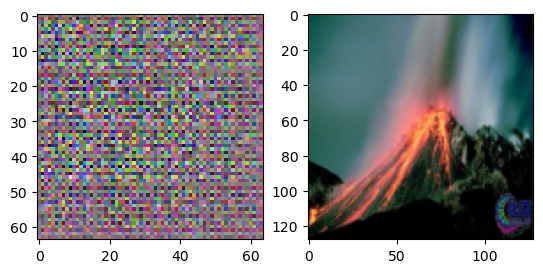

In [125]:
decoder = Decoder()
decoder = decoder.to(device)
sample_untrained_out = try_running_image(sample_image, encoder, decoder)
display_images([sample_untrained_out, sample_image])

In [126]:

def try_running_image(img, encoder, decoder):
	img = img.to(device)
	img = img.unsqueeze(0)
	embedding = encoder(img)
	out = decoder(embedding)[0]
	return out.cpu()

# Train  

In [127]:
from tqdm import tqdm

encoder = Encoder()
encoder = encoder.to(device)
decoder = Decoder()
decoder = decoder.to(device)

In [128]:
optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.01)
loss_fn = nn.MSELoss()

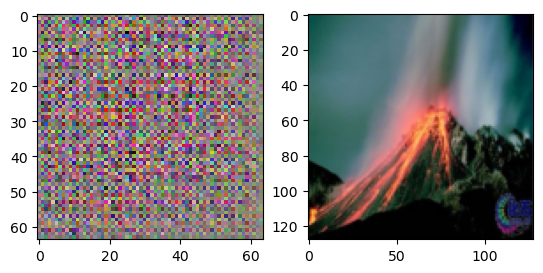

In [129]:
sample_untrained_out = try_running_image(sample_image, encoder, decoder)
display_images([sample_untrained_out, sample_image])

100%|██████████| 21/21 [00:04<00:00,  4.29it/s]


Epoch Loss: 0.24635910522192717


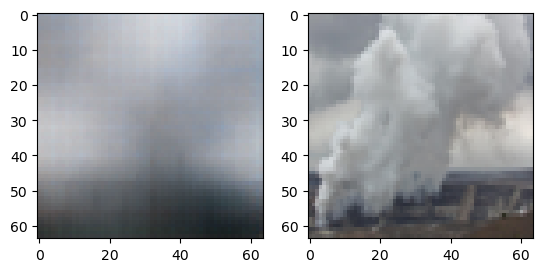

In [185]:
EPOCHS = 100
for epcoh in range(EPOCHS):
	encoder.train()
	decoder.train()
	

	epoch_loss = 0
	total_number_of_images = len(train_loader)
	for index, batch in tqdm(enumerate(train_loader), total=total_number_of_images):
		data, _ = batch
		data = data.to(device)
		optim.zero_grad()

		embedded_images = encoder(data)
		decoded_images = decoder(embedded_images)


		loss = loss_fn(get_center_of_image(data), decoded_images)
		loss.backward()
		epoch_loss += loss.item()
		optim.step()
		display_images([decoded_images[0], get_center_of_image(data)[0]])
	print(f"Epoch Loss: {epoch_loss}")